In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from collections import Counter
from matplotlib import pyplot as plt

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')
pd.set_option('display.max_columns', 200)

In [5]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет:
df_train['sample'] = 1 # помечаем где у нас тренировочные данные
df_test['sample'] = 0 # помечаем где у нас тестовые данные
df_test['Rating'] = 0 # в тестовых у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [6]:
# переименуем столбцы чтобы было проще к ним обращаться
df.rename(columns={'Restaurant_id': 'restaurant_id', 'City': 'city', 'Cuisine Style': 'cuisine_style',
                   'Ranking': 'ranking', 'Rating': 'rating', 'Price Range': 'price_range',
                   'Number of Reviews': 'number_reviews', 'Reviews': 'reviews', 'URL_TA': 'url_ta', 'ID_TA': 'id_ta'},
          inplace=True)

In [7]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating', 'restaurant_id', 'city', 'cuisine_style', 'price_range', 'reviews',
                     'url_ta', 'id_ta', ], axis=1).fillna(0)

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [8]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 10), (40000, 10), (40000, 2), (32000, 2), (8000, 2))

In [9]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [10]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [11]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', np.square(np.subtract(y_test, y_pred)).mean())
MSE = np.square(np.subtract(y_test, y_pred)).mean()
print('RMSE:', np.sqrt(MSE))
MAE = metrics.mean_absolute_error(y_test, y_pred)

MAE: 0.42548655925324674
MSE: 0.35918503279774255
RMSE: 0.5993204758705835


# Функции для обработки

In [12]:
def boxplot(col):
    '''Выводит для столбца боксплот'''
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=col, y='rating', data=df,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + col)
    plt.show()


def search_outliers(col):
    '''Считает для каждого стобца границы выбросов'''
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    print(
        f'Границы выбросов в столбце {col} - [{df[col].quantile(0.25)-1.5*IQR}; {df[col].quantile(0.75)+1.5*IQR}]')


def missing_values(col):
    '''Показывает кол-во и процент пропущенных значений'''
    missing_value_percent = round(df[col].isnull().mean()*100, 2)
    print(
        f'Процент пропущенных значений в столбце {col} - {missing_value_percent}%')
    print(
        f'Всего пропущенных значений в столбце {col} - {df[col].isnull().sum()}')


def info_col(col):
    '''Показывает количество уникальных значений, колличество для каждого значения, информацию о столбце'''
    display(df[col].unique())
    display(pd.DataFrame(df[col].value_counts()))
    display(df.loc[:, [col]].describe())


def replace_symbols(text):
    '''Удалит все не нужные символы в строке'''
    for ch in ['[', ']', "'", '"', ' ']:
        if ch in text:
            text = text.replace(ch, '')
    return text

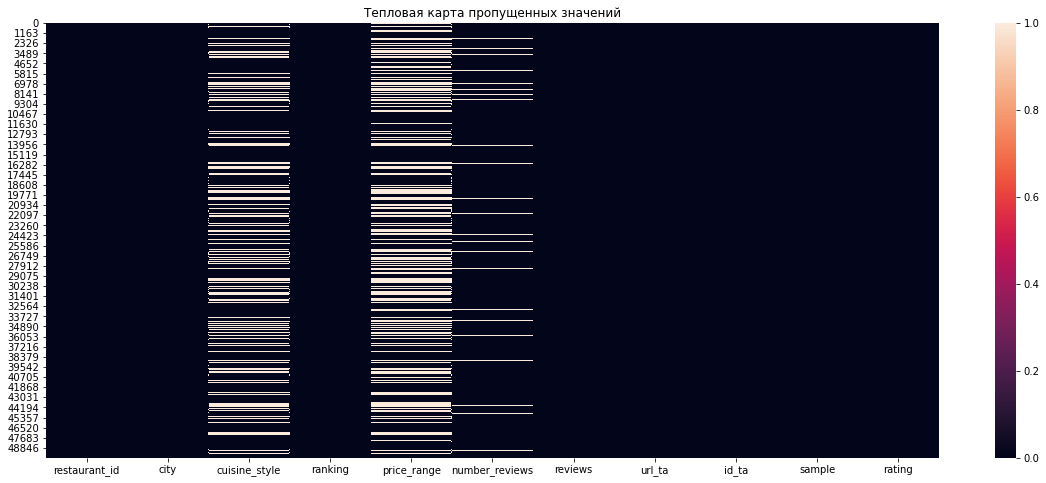

Процент пропущенных значений в столбце restaurant_id - 0.0%
Процент пропущенных значений в столбце city - 0.0%
Процент пропущенных значений в столбце cuisine_style - 23.18%
Процент пропущенных значений в столбце ranking - 0.0%
Процент пропущенных значений в столбце price_range - 34.72%
Процент пропущенных значений в столбце number_reviews - 6.4%
Процент пропущенных значений в столбце reviews - 0.0%
Процент пропущенных значений в столбце url_ta - 0.0%
Процент пропущенных значений в столбце id_ta - 0.0%
Процент пропущенных значений в столбце sample - 0.0%
Процент пропущенных значений в столбце rating - 0.0%


In [13]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(df.isnull(), ax=ax)
ax.set_title('Тепловая карта пропущенных значений')
plt.show()


for i in df.columns:
    missing_value_percent = round(df[i].isnull().mean()*100, 2)
    print(
        f'Процент пропущенных значений в столбце {i} - {missing_value_percent}%')

# Проведем предварительный анализ для каждого столбца¶


In [14]:
col = 'restaurant_id'
info_col(col)
print('\t')
missing_values(col)

array(['id_0', 'id_1', 'id_2', ..., 'id_15736', 'id_12774', 'id_11658'],
      dtype=object)

,restaurant_id
id_633,19
id_436,19
id_227,19
id_871,19
id_344,18
...,...
id_14221,1
id_12494,1
id_12144,1
id_6402,1


,restaurant_id
count,50000
unique,13094
top,id_633
freq,19


	
Процент пропущенных значений в столбце restaurant_id - 0.0%
Всего пропущенных значений в столбце restaurant_id - 0


In [15]:
df.restaurant_id = df.restaurant_id.str.replace('id_', '')

In [16]:
df.restaurant_id = df.restaurant_id.apply(lambda x: int(x))

In [17]:
count_restaraunt_id = df.restaurant_id.value_counts()
# если в сеть рестаранов входит больше 3 заведений то отмечаем что это сеть
df['restaraunt_chain'] = df.restaurant_id.apply(lambda x: 1 if count_restaraunt_id.loc[x]>3 else 0)

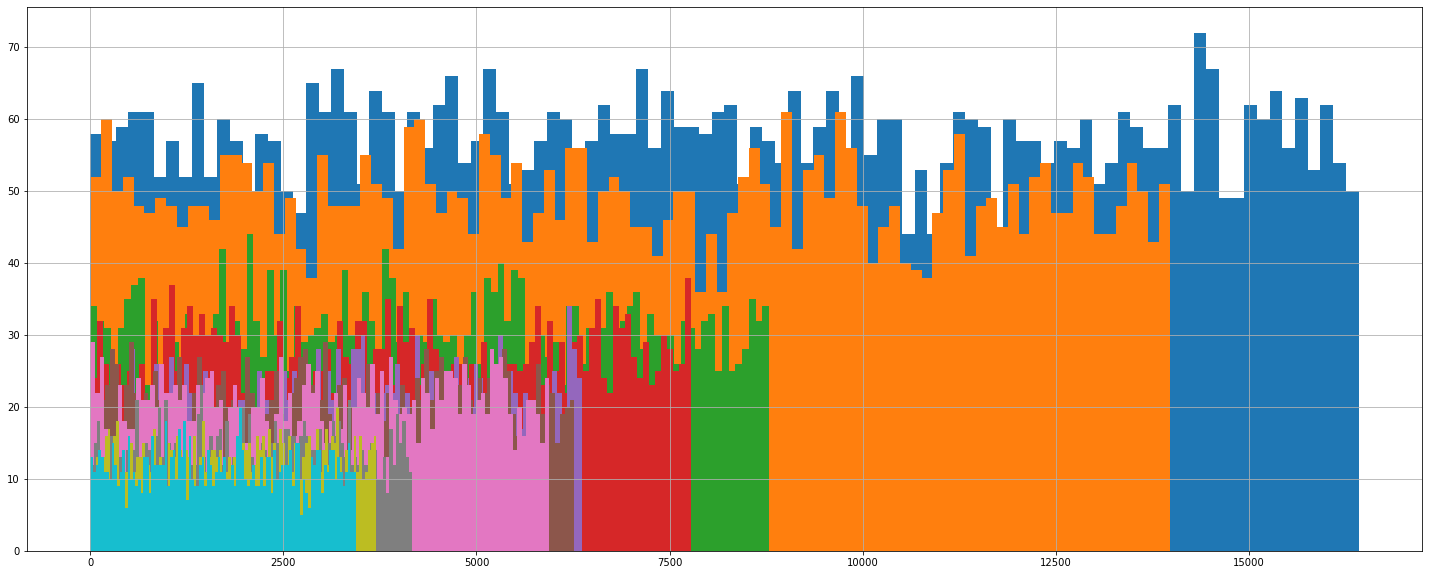

In [18]:
plt.figure(figsize=[25,10])
for x in (df.query('sample==1').city.value_counts())[0:10].index:
    df.query('sample==1').restaurant_id[df.query('sample==1').city == x].hist(bins=100)
plt.show()

restaraunt_id очень похож на ranking, думаю что в дальнейшем его можно будет удалить, если подтвердится корреляция

ИТОГ:
1. restaurant_id - удалили id_ и перевели в int
2. restaraunt_chain - входит ли ресторан в сеть или нет (сеть от 3 ресторанов)

In [19]:
col = 'city'
info_col(col)
print('\t')
missing_values(col)

array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

,city
London,7193
Paris,6108
Madrid,3813
Barcelona,3395
Berlin,2705
Milan,2694
Rome,2589
Prague,1816
Lisbon,1647
Vienna,1443


,city
count,50000
unique,31
top,London
freq,7193


	
Процент пропущенных значений в столбце city - 0.0%
Всего пропущенных значений в столбце city - 0


In [20]:
col = 'cuisine_style'
missing_values(col)

Процент пропущенных значений в столбце cuisine_style - 23.18%
Всего пропущенных значений в столбце cuisine_style - 11590


В столбце данные записаны в неудобном формате, приведем их к удобному виду

In [21]:
# удалил лишние символы
df.cuisine_style = df.cuisine_style.apply(lambda x: replace_symbols(x) if pd.notna(x) else x)

In [22]:
df['cuisine_style_isNAN'] = pd.isna(df.cuisine_style).astype('uint8')

In [23]:
df.cuisine_style = df.cuisine_style.str.split(',')

In [24]:
# пока заменим все пропуски наиболее часто встречающимся видом кухни
df.cuisine_style.fillna('Unknown', inplace=True)

In [25]:
# получили наиболее часто встречающийся вид кухни
top_cuisine_style = df.explode('cuisine_style').cuisine_style.value_counts()
top_cuisine_style

VegetarianFriendly    14021
European              12561
Unknown               11590
Mediterranean          7820
Italian                7433
                      ...  
Polynesian                2
Xinjiang                  1
Burmese                   1
Latvian                   1
Salvadoran                1
Name: cuisine_style, Length: 126, dtype: int64

In [26]:
# сколько видов кухни в ресторане
df['cuisine_in_rest'] = df.cuisine_style.apply(lambda x: len(x))

In [27]:
mean_cuisine_in_rest_by_city = df.groupby('city')['cuisine_in_rest'].mean()

In [28]:
# сколько видов кухни в ресторане в среднем по городу
df['mean_cuisine_in_rest_by_city'] = df.city.apply(lambda x: mean_cuisine_in_rest_by_city.loc[x] )

ИТОГ:
1. df.cuisine_style_isNAN - пропущенные значения по кухням
2. df.cuisine_in_rest - сколько видов кухни в ресторане
3. df.mean_cuisine_in_rest_by_city - сколько видов кухни в ресторане в среднем по городу

In [29]:
col = 'ranking'
missing_values(col)

Процент пропущенных значений в столбце ranking - 0.0%
Всего пропущенных значений в столбце ranking - 0


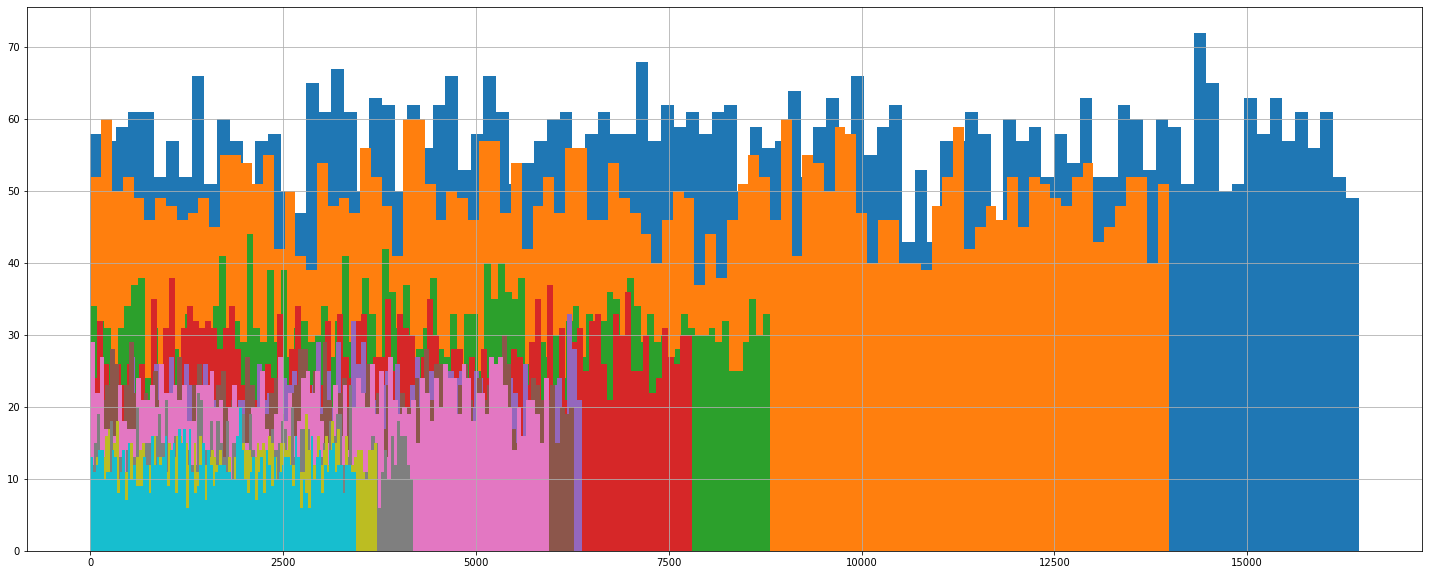

In [30]:
# посмотрим на топ 10 городов
plt.figure(figsize=[25,10])
for x in (df.query('sample==1').city.value_counts())[0:10].index:
    df.query('sample==1').ranking[df.query('sample==1').city == x].hist(bins=100)
plt.show()

In [31]:
# максимальный ранг по городу
max_ranking_on_city = df.groupby(['city'])['ranking'].max()
df['max_ranking_on_city'] = df.city.apply(lambda x: max_ranking_on_city[x])
min_ranking_on_city = df.groupby(['city'])['ranking'].min()
df['min_ranking_on_city'] = df.city.apply(lambda x: min_ranking_on_city[x])

In [32]:
# нормированный ранг по каждому городу
df['norm_ranking_on_MAX_MINRank'] = (
    df.ranking - df.min_ranking_on_city) / (df.max_ranking_on_city - df.min_ranking_on_city)

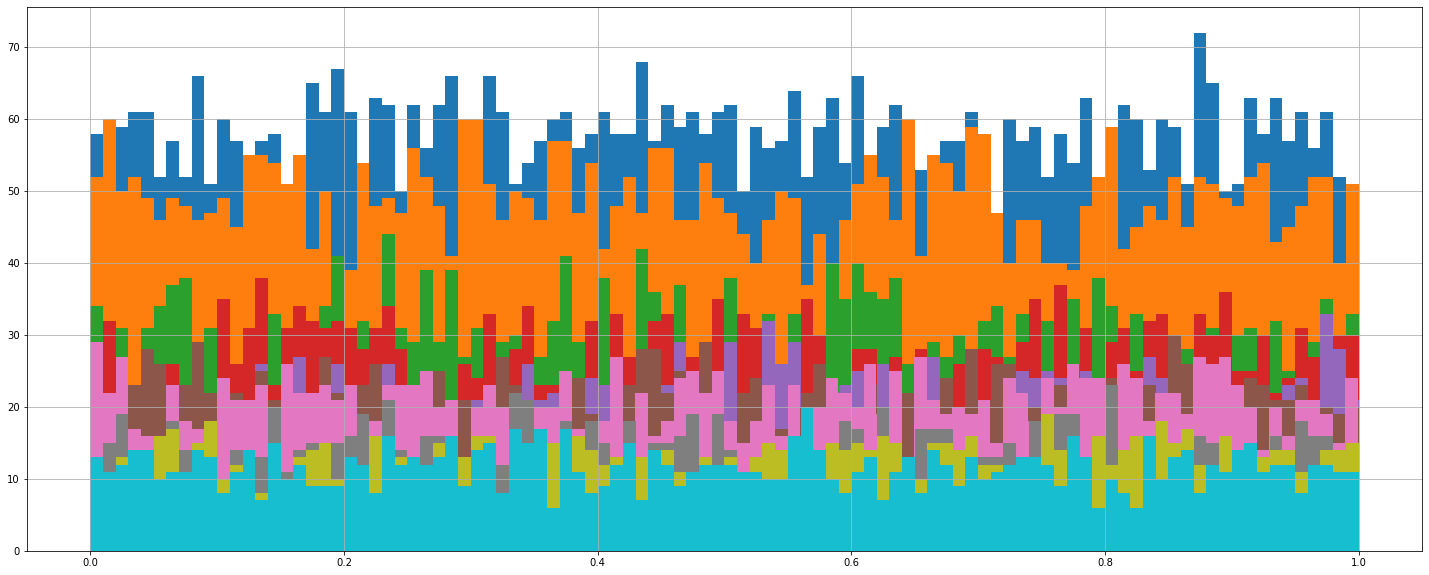

In [33]:
# посмотрим на топ 10 городов после нормализации
plt.figure(figsize=[25,10])
for x in (df.query('sample==1').city.value_counts())[0:10].index:
    df.query('sample==1').norm_ranking_on_MAX_MINRank[df.query('sample==1').city == x].hist(bins=100)
plt.show()

ИТОГ:
1. df.max_ranking_on_city - максимальный ранг по городу
2. df.min_ranking_on_city - минимальный ранг по городу
3. df.norm_ranking_on_MAX_MINRank - нормированный ранг по каждому городу

In [34]:
col = 'rating'
info_col(col)
print('\t')
missing_values(col)

array([0. , 3.5, 4. , 4.5, 5. , 3. , 2.5, 2. , 1. , 1.5])

,rating
4.0,13692
4.5,10929
0.0,10000
3.5,6824
5.0,3879
3.0,2955
2.5,915
2.0,466
1.0,201
1.5,139


,rating
count,50000.000000
mean,3.194430
std,1.705453
min,0.000000
25%,3.000000
50%,4.000000
75%,4.500000
max,5.000000


	
Процент пропущенных значений в столбце rating - 0.0%
Всего пропущенных значений в столбце rating - 0


In [35]:
col = 'price_range'
info_col(col)
print('\t')
missing_values(col)

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

,price_range
$$ - $$$,23041
$,7816
$$$$,1782


,price_range
count,32639
unique,3
top,$$ - $$$
freq,23041


	
Процент пропущенных значений в столбце price_range - 34.72%
Всего пропущенных значений в столбце price_range - 17361


In [36]:
df.price_range.value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [37]:
df['price_range_isNAN'] = pd.isna(df.price_range).astype('uint8')

In [38]:
# переименовал $ в слова так как значки плохо отображаются
df.price_range = df.price_range.apply(lambda x: x if pd.isna(x) else(
    'cheaply' if x == '$' else ('average' if x == '$$ - $$$' else ('expensive'))))

In [39]:
# такой вид заполнения давал чуть более лучший результат
df.price_range.fillna(method='bfill', inplace=True)

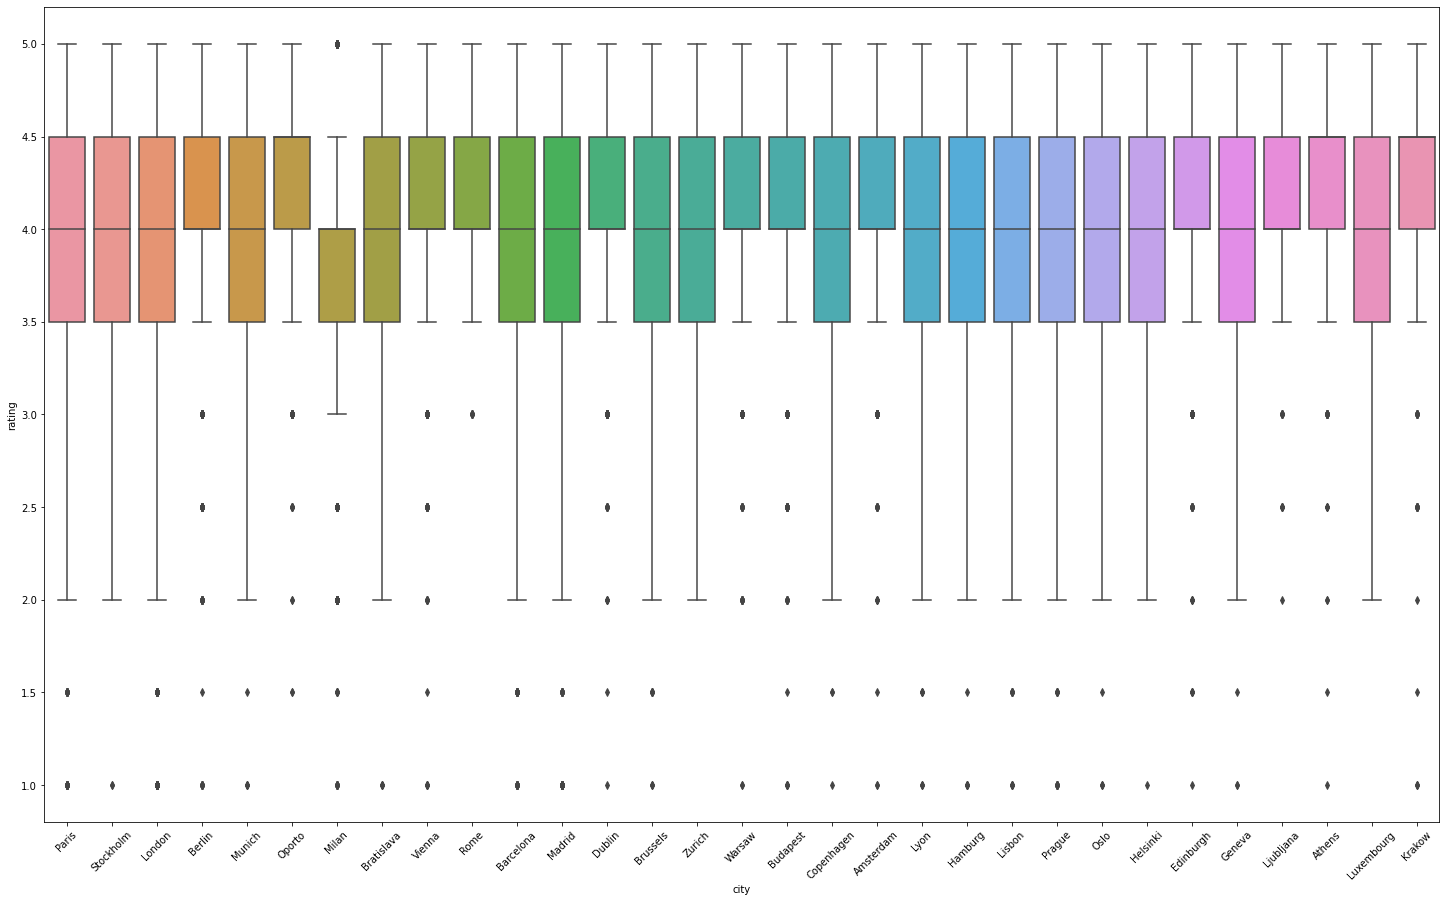

In [40]:
plt.figure(figsize=[25, 15])
sns.boxplot(x=df.query('sample==1').city, y=df.rating)
plt.xticks(rotation=45)
plt.show()

Думаю, что признак price_range не особо улучшит нашу модель.

In [41]:
info_col(col)
print('\t')
missing_values(col)

array(['average', 'expensive', 'cheaply'], dtype=object)

,price_range
average,35297
cheaply,12019
expensive,2684


,price_range
count,50000
unique,3
top,average
freq,35297


	
Процент пропущенных значений в столбце price_range - 0.0%
Всего пропущенных значений в столбце price_range - 0


ИТОГ:
1. Заменили значки долларов на cheaply, average, expensive
2. Пропуски заполнили методом bfill
3. df.price_range_isNAN - пропущенные значения price_range

In [42]:
col = 'number_reviews'
info_col(col)
print('\t')
missing_values(col)
print('\t')
search_outliers(col)

array([   4.,   97.,   28., ...,  765., 2272., 2297.])

,number_reviews
2.0,2403
3.0,2042
4.0,1707
5.0,1471
6.0,1258
...,...
1330.0,1
1169.0,1
2148.0,1
8927.0,1


,number_reviews
count,46800.000000
mean,124.471197
std,294.114345
min,2.000000
25%,9.000000
50%,33.000000
75%,115.000000
max,9660.000000


	
Процент пропущенных значений в столбце number_reviews - 6.4%
Всего пропущенных значений в столбце number_reviews - 3200
	
Границы выбросов в столбце number_reviews - [-150.0; 274.0]


In [43]:
df['number_of_reviews_isNAN'] = pd.isna(df.number_reviews).astype('uint8')

In [44]:
min_review_on_city = df.groupby(['city'])['number_reviews'].min()
df['min_review_on_city'] = df.city.apply(lambda x: min_review_on_city[x])

In [45]:
max_review_on_city = df.groupby(['city'])['number_reviews'].max()
df['max_review_on_city'] = df.city.apply(lambda x: max_review_on_city[x])

In [46]:
# заполним пропуски 0, чтобы не было ошибки
df.number_reviews.fillna(0, inplace=True)

In [47]:
df['norm_number_review'] = (df.number_reviews - df.min_review_on_city) / \
    (df.max_review_on_city - df.min_review_on_city)

In [48]:
# отрицательные значения заменим на 0
df.norm_number_review = df.norm_number_review.apply(lambda x: 0 if x<0 else x)

ИТОГО:
1. df.number_of_reviews_isNAN - пропуски в number_of_reviews
2. df.min_review_on_city - минимальный колличество отзывов ресторане по городу
3. df.max_review_on_city - максимальное колличество отзывов ресторане по городу
4. df.norm_number_review - нормированное число отзывов по каждому городу (Max_Min)

In [49]:
col = 'reviews'
info_col(col)
print('\t')
missing_values(col)

array(['[[], []]',
       "[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]",
       "[['Better than the Links', 'Ivy Black'], ['12/28/2017', '12/06/2017']]",
       ...,
       "[['Good by swedish standards', 'A hidden jewel in the middle of Västertorp...'], ['11/03/2016', '04/12/2008']]",
       "[['Underground restaurant', 'Oldest Restaurant in Warsaw'], ['07/11/2017', '06/18/2017']]",
       "[['Average', 'Nice an informal'], ['01/31/2016', '07/04/2012']]"],
      dtype=object)

,reviews
"[[], []]",8112
"[['Great Asian Option', 'Wow'], ['10/16/2017', '09/07/2016']]",2
"[['Excellent cuisine, friendly and helpful se...', 'Not tasty'], ['12/25/2016', '06/05/2016']]",2
"[['ok for beer, not for dinner'], ['12/20/2017']]",2
"[['Excellent'], ['09/03/2015']]",2
...,...
"[['Quality kebabs', 'Enjoying friendly dinner'], ['10/02/2017', '09/18/2017']]",1
"[['Nice Place', 'Watch Paris go by...'], ['10/14/2017', '09/05/2017']]",1
"[['Go for the view, not for the food', 'Sun kissed roof'], ['07/16/2016', '06/03/2016']]",1
"[['Absolutely authentic Polish restaurant', 'Raw Chicken!!!!!!!! (Photos attached)'], ['12/03/2017', '11/22/2017']]",1


,reviews
count,49998
unique,41857
top,"[[], []]"
freq,8112


	
Процент пропущенных значений в столбце reviews - 0.0%
Всего пропущенных значений в столбце reviews - 2


In [50]:
df.reviews = df.reviews.fillna('[[], []]')

In [51]:
df['reviews_isNAN'] = (df.reviews == '[[], []]').astype('uint8')

In [52]:
df['date_review'] = df.reviews.str.findall('\d+/\d+/\d+')
df.date_review

0                              []
1        [12/05/2017, 10/29/2017]
2        [12/28/2017, 12/06/2017]
3        [12/06/2017, 11/22/2017]
4        [02/08/2018, 01/24/2018]
                   ...           
49995    [12/16/2017, 11/12/2017]
49996    [12/21/2017, 12/12/2017]
49997    [11/03/2016, 04/12/2008]
49998    [07/11/2017, 06/18/2017]
49999    [01/31/2016, 07/04/2012]
Name: date_review, Length: 50000, dtype: object

In [53]:
df.date_review.str.len().unique()

array([0, 2, 1, 3])

Видим, что есть значения с тремя датами. Посмотрим, что это за значения.

In [54]:
# видим, что пользователи указывали в отзывах дату когда они были
df.reviews[df.date_review.str.len() > 2].iloc[0]

"[['We visited 21/10/17', 'Best Kebab in London'], ['12/22/2017', '10/19/2017']]"

In [55]:
# удалим эту дату
df.date_review = df.date_review.apply(lambda x: x if len(x) <= 2 else x[1:])

In [56]:
date_of_fresh_review = pd.to_datetime(df.explode('date_review').date_review).max()

In [57]:
df['len_date'] = df.date_review.apply(lambda x: len(x))

In [58]:
def time_to_now(x):
    '''Считает разницу во времени между датой самого свежего 
    отзыва по всему датасету и датой самого свежего отзыва для каждого ресторана '''
    if x == []:
        return None
    return date_of_fresh_review - pd.to_datetime(x).max()


def time_between_Reviews(x):
    '''Считает разницу во времени между датой самого свежего 
    отзыва для каждого ресторана и датой предыдущего отзыва для каждого ресторана'''
    if x == []:
        return None
    return pd.to_datetime(x).max() - pd.to_datetime(x).min()


df['diff_day_to_fresh_review'] = df.date_review.apply(time_to_now).dt.days
df['diff_day_last_penultimate_comment'] = df[df['len_date']
                                             == 2].date_review.apply(time_between_Reviews).dt.days

In [59]:
df.diff_day_last_penultimate_comment.fillna(0, inplace=True)
df.diff_day_to_fresh_review.fillna(0, inplace=True)

In [60]:
df['norm_rank_ON_norm_review'] = df.norm_ranking_on_MAX_MINRank * \
    df.norm_number_review

In [61]:
df['ranking_ON_num_reviews'] = df.ranking * df.number_reviews

ИТОГО:
1. df.len_date - количество дат
2. df.diff_day_to_fresh_review - разница во времени между датой самого свежего отзыва по всему датасету и датой самого свежего отзыва для каждого ресторана
3. df.diff_day_last_penultimate_comment - разница во времени между датой самого свежего отзыва для каждого ресторана и датой предыдущего отзыва для каждого ресторана
4. df.norm_rank_ON_norm_review - перемножим нормированый ранг на нормированый отзыв
5. df.ranking_ON_num_reviews - перемножим ранг на количество отзывов

In [62]:
col = 'url_ta'
info_col(col)
print('\t')
missing_values(col)

array(['/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html',
       '/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html',
       '/Restaurant_Review-g186525-d13129638-Reviews-Black_Ivy-Edinburgh_Scotland.html',
       ...,
       '/Restaurant_Review-g189852-d947615-Reviews-Sushi_Bar_Anu-Stockholm.html',
       '/Restaurant_Review-g274856-d1100838-Reviews-Honoratka_dawna_Oberza_na_Miodowej-Warsaw_Mazovia_Province_Central_Poland.html',
       '/Restaurant_Review-g187849-d1109020-Reviews-Taberna_Vasca-Milan_Lombardy.html'],
      dtype=object)

,url_ta
/Restaurant_Review-g187514-d7337366-Reviews-Lady_Madonna-Madrid.html,2
/Restaurant_Review-g187514-d7342803-Reviews-Los_Hierros-Madrid.html,2
/Restaurant_Review-g187514-d2010743-Reviews-Restaurant_Furusato-Madrid.html,2
/Restaurant_Review-g187514-d2669414-Reviews-Vips-Madrid.html,2
/Restaurant_Review-g187514-d10047799-Reviews-Entrepuntos-Madrid.html,2
...,...
/Restaurant_Review-g186338-d6524613-Reviews-La_Casa_Del_Burrito-London_England.html,1
/Restaurant_Review-g187147-d8777888-Reviews-Le_Gevaudan-Paris_Ile_de_France.html,1
/Restaurant_Review-g187309-d1873176-Reviews-China_Moon_Roof_Terrace-Munich_Upper_Bavaria_Bavaria.html,1
/Restaurant_Review-g187849-d1097509-Reviews-Don_Carlos_Restaurant-Milan_Lombardy.html,1


,url_ta
count,50000
unique,49963
top,/Restaurant_Review-g187514-d7337366-Reviews-La...
freq,2


	
Процент пропущенных значений в столбце url_ta - 0.0%
Всего пропущенных значений в столбце url_ta - 0


In [63]:
col = 'id_ta'
info_col(col)
print('\t')
missing_values(col)

array(['d10746918', 'd6674944', 'd13129638', ..., 'd947615', 'd1100838',
       'd1109020'], dtype=object)

,id_ta
d9877640,2
d4914988,2
d1568045,2
d10316215,2
d2360290,2
...,...
d2363637,1
d10127452,1
d11929432,1
d10934451,1


,id_ta
count,50000
unique,49963
top,d9877640
freq,2


	
Процент пропущенных значений в столбце id_ta - 0.0%
Всего пропущенных значений в столбце id_ta - 0


In [64]:
df.id_ta = df.id_ta.apply(lambda x: int(x[1:]))

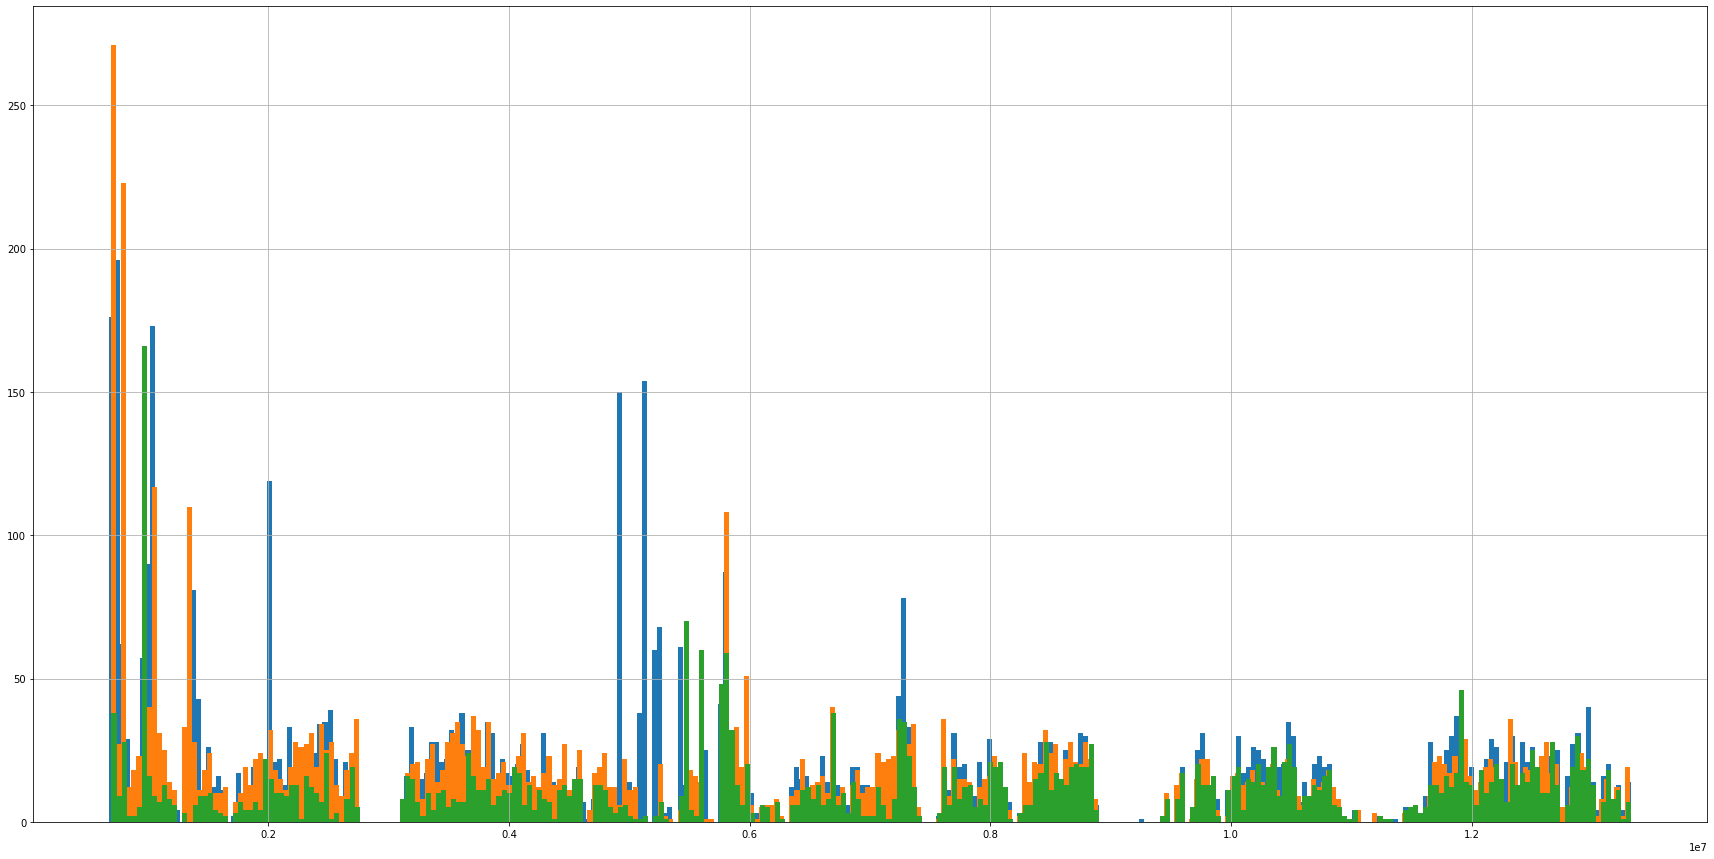

In [65]:
plt.figure(figsize=[30,15])
for x in (df.query('sample==1').city.value_counts())[0:3].index:
    df.query('sample==1').id_ta[df.query('sample==1').city == x].hist(bins=300)
plt.show()

Видим, что на графике формируются группы. Не похоже на id.

In [66]:
df = pd.get_dummies(df, columns=['price_range', 'city'])

# Модель

In [67]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)


y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating', 'ranking', 'len_date', 'restaurant_id',
                     'cuisine_style', 'reviews', 'url_ta', 'date_review'], axis=1)

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [68]:
def round_(x):
    a = x-x//1
    if 0.25 <= round(a, 1) < 0.75:
        return x//1+0.5
    elif round(a, 1) < 0.25:
        return x//1
    return x//1+1


my_vec_round = np.vectorize(round_)

In [69]:
y_pred = my_vec_round(y_pred)

In [70]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются  
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.  
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  

MAE: 0.160125


<AxesSubplot:>

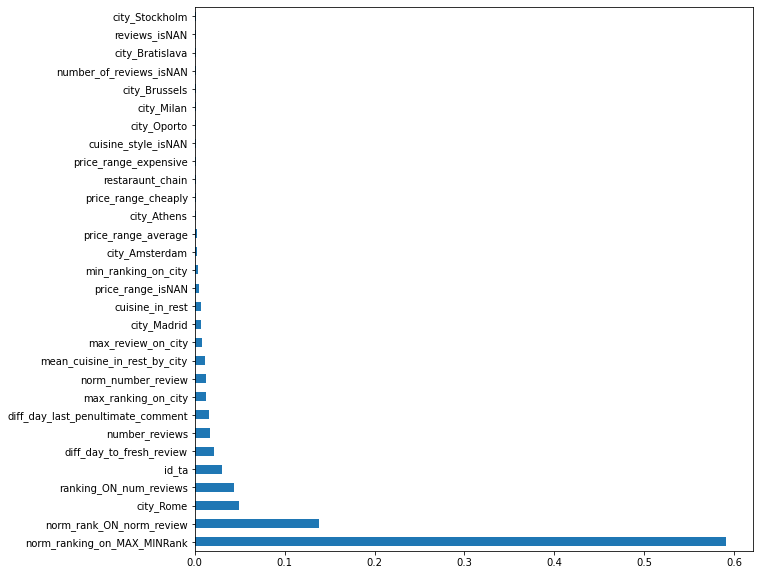

In [71]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

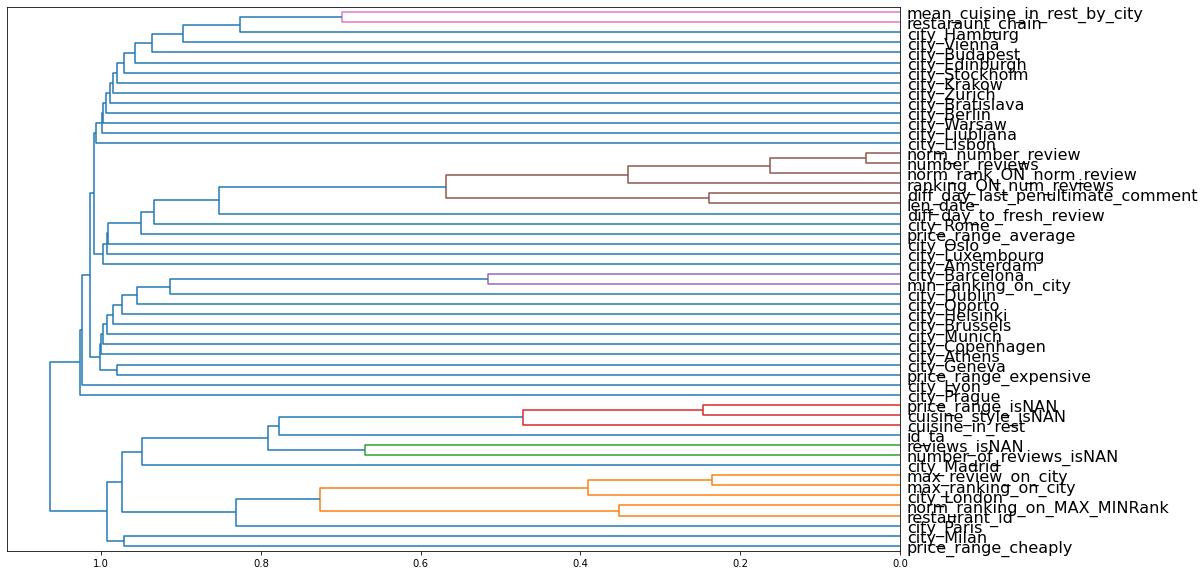

In [72]:
from scipy import stats
from scipy.cluster import hierarchy as hc
corr = np.round(stats.spearmanr(train_data.drop(
    ['rating', 'min_review_on_city', 'ranking', 'cuisine_style', 'reviews', 'url_ta', 'date_review', ], axis=1)).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16, 10))
dendrogram = hc.dendrogram(z, labels=train_data.drop(['rating', 'min_review_on_city', 'ranking', 'cuisine_style', 'reviews', 'url_ta', 'date_review', ], axis=1).columns,
                           orientation='left', leaf_font_size=16)
plt.show()

In [73]:
feat_importances.sort_values(ascending=False)

norm_ranking_on_MAX_MINRank          0.591213
norm_rank_ON_norm_review             0.137683
city_Rome                            0.048637
ranking_ON_num_reviews               0.043591
id_ta                                0.030592
diff_day_to_fresh_review             0.021337
number_reviews                       0.017181
diff_day_last_penultimate_comment    0.015974
max_ranking_on_city                  0.012862
norm_number_review                   0.012513
mean_cuisine_in_rest_by_city         0.011538
max_review_on_city                   0.008409
city_Madrid                          0.007336
cuisine_in_rest                      0.006973
price_range_isNAN                    0.004318
min_ranking_on_city                  0.003057
city_Amsterdam                       0.002243
price_range_average                  0.001885
city_Athens                          0.001821
price_range_cheaply                  0.001792
restaraunt_chain                     0.001342
price_range_expensive             

# Submission

In [74]:
test_data.sample(10)

,restaurant_id,cuisine_style,ranking,number_reviews,reviews,url_ta,id_ta,rating,restaraunt_chain,cuisine_style_isNAN,cuisine_in_rest,mean_cuisine_in_rest_by_city,max_ranking_on_city,min_ranking_on_city,norm_ranking_on_MAX_MINRank,price_range_isNAN,number_of_reviews_isNAN,min_review_on_city,max_review_on_city,norm_number_review,reviews_isNAN,date_review,len_date,diff_day_to_fresh_review,diff_day_last_penultimate_comment,norm_rank_ON_norm_review,ranking_ON_num_reviews,price_range_average,price_range_cheaply,price_range_expensive,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
3397,3397,"[Italian, Pizza, Seafood, Mediterranean, Europ...",2693.0,245.0,"[['Decent restaurant, nice cheese platter and....",/Restaurant_Review-g187849-d1635089-Reviews-Al...,1635089,0.0,0,0,6,4.054566,6275.0,1.0,0.429072,0,0,2.0,6360.0,0.038220,0,"[12/14/2017, 09/12/2017]",2,74.0,93.0,0.016399,659785.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8664,8664,"[Italian, Mediterranean, European, VegetarianF...",2028.0,71.0,"[['Carpaccio, Pizza and Squid', 'Italian the p...",/Restaurant_Review-g187309-d958013-Reviews-La_...,958013,0.0,0,0,4,4.183406,2763.0,3.0,0.733696,0,0,2.0,4694.0,0.014706,0,"[11/30/2017, 09/20/2017]",2,88.0,71.0,0.010790,143988.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5232,5232,Unknown,3074.0,13.0,"[['Excellent staff and location', 'not bad for...",/Restaurant_Review-g187514-d8462251-Reviews-Ho...,8462251,0.0,1,1,7,3.961972,8809.0,1.0,0.348887,1,0,2.0,6013.0,0.001830,0,"[07/25/2016, 07/17/2016]",2,581.0,8.0,0.000638,39962.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
680,680,"[Cafe, British, VegetarianFriendly, GlutenFree...",14189.0,56.0,"[['Friendly place for Coffee and Cake', 'Nice ...",/Restaurant_Review-g186338-d5443514-Reviews-Ca...,5443514,0.0,1,0,4,3.978451,16444.0,1.0,0.862860,0,0,2.0,9660.0,0.005591,0,"[11/22/2017, 11/20/2017]",2,96.0,2.0,0.004824,794584.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2672,2672,Unknown,3260.0,7.0,"[['Open late!'], ['05/25/2016']]",/Restaurant_Review-g190454-d5986431-Reviews-Bi...,5986431,0.0,0,1,7,4.414414,3444.0,1.0,0.946558,1,0,2.0,4937.0,0.001013,0,[05/25/2016],1,642.0,0.0,0.000959,22820.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5761,5761,[Spanish],4020.0,0.0,"[[], []]",/Restaurant_Review-g187514-d12709056-Reviews-T...,12709056,0.0,1,0,1,3.961972,8809.0,1.0,0.456290,1,1,2.0,6013.0,0.000000,1,[],0,0.0,0.0,0.000000,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5998,5998,[French],3264.0,251.0,"[['Truly Awesome', 'Nice little spot near St. ...",/Restaurant_Review-g187147-d1391360-Reviews-Le...,1391360,0.0,1,0,1,3.426817,13986.0,3.0,0.233212,0,0,2.0,7622.0,0.032677,0,"[12/24/2017, 07/27/2017]",2,64.0,150.0,0.007621,819264.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1252,1252,[Pub],5917.0,2.0,"[[], []]",/Restaurant_Review-g187514-d990776-Reviews-Res...,990776,0.0,1,0,1,3.961972,8809.0,1.0,0.671662,1,0,2.0,6013.0,0.000000,1,[],0,0.0,0.0,0.000000,11834.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8239,8239,Unknown,15193.0,3.0,"[['Messed up my order.', 'Fresh and airy!'], [...",/Restaurant_Review-g186338-d9857580-Reviews-Ea...,9857580,0.0,0,1,7,3.978451,16444.0,1.0,0.923919,1,0,2.0,9660.0,0.000104,0,"[04/26/2017, 09/28/2016]",2,306.0,210.0,0.000096,45579.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9981,9981,"[Italian, Pizza, Mediterranean, VegetarianFrie...",827.0,52.0,[['One of the best and biggest pizzas that we....,/Restaurant_Rev

In [75]:
test_data = test_data.drop(['rating', 'ranking', 'len_date', 'restaurant_id',
                            'cuisine_style', 'reviews', 'url_ta', 'date_review'], axis=1)

In [76]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [77]:
predict_submission

array([3.065, 4.295, 4.245, ..., 3.005, 4.445, 4.43 ])

In [78]:
predict_submission = my_vec_round(predict_submission)
predict_submission

array([3. , 4.5, 4. , ..., 3. , 4.5, 4.5])

In [79]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(15)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.5
8,id_8,4.0
9,id_9,4.5
